# K Nearest Neighbors: Predicting King County Housing Prices

### How to predict the price of a house about to be put on the market?


## Les maisons similaires doivent avoir un prix similaire

* la superficie
* Nombre d'étages
* L'emplacement


## La distance comme mesure de similarité

Quelle est la distance qui sépare les maisons les unes des autres, compte tenu de toutes leurs caractéristiques ?


## Qu'est-ce que les K-voisins les plus proches ?

**_K-Nearest Neighbors_** (ou KNN, en abrégé) est un algorithme d'apprentissage supervisé qui peut être utilisé à la fois pour les tâches de **_Classification_** et de **_Régression_**. Le KNN est un classificateur basé sur la distance, ce qui signifie qu'il suppose implicitement que plus la distance entre deux points est faible, plus ils sont similaires. Dans le KNN, chaque colonne joue le rôle d'une dimension. Dans un ensemble de données comportant deux colonnes, nous pouvons facilement visualiser cela en traitant les valeurs d'une colonne comme des coordonnées X et celles de l'autre comme des coordonnées Y. Comme il s'agit d'un **algorithme d'apprentissage supervisém_**, nous devons également disposer des étiquettes pour chaque point de notre ensemble de données, faute de quoi nous ne pourrons pas utiliser cet algorithme pour la prédiction.

## Ajustement du modèle

KNN se distingue des autres algorithmes par le fait qu'il ne fait presque rien pendant l'étape d'"ajustement", et tout le travail pendant l'étape de "prédiction". Au cours de l'étape d'ajustement, KNN se contente de stocker toutes les données d'apprentissage et les valeurs correspondantes. Aucune distance n'est calculée à ce stade. 

## Faire des prédictions avec K

Toute la magie opère lors de l'étape "prédire". Au cours de cette étape, KNN prend un point pour lequel nous voulons une prédiction de classe et calcule les distances entre ce point et chaque point de l'ensemble d'apprentissage. Il trouve ensuite les `K` points les plus proches, ou **_Voisins_**, et examine les valeurs de chacun d'entre eux. Vous pouvez considérer que chacun des K points les plus proches obtient un "vote" sur la valeur prédite. Souvent, la moyenne de toutes les valeurs est utilisée pour prédire le nouveau point.

Dans l'animation suivante, K=3.
<img src="https://miro.medium.com/v2/resize:fit:1080/1*4WmlYuK1E7d6asSvlQpEjg.gif" alt="Alternative text" />


## Métriques de distance

Comme nous l'avons vu dans une leçon précédente, il existe différentes **_métriques de distance_** lors de l'utilisation de KNN. Pour le KNN, nous pouvons utiliser **_Manhattan**, **_Euclidean_**, ou **_Minkowski Distance_** - d'un point de vue algorithmique, peu importe laquelle ! Cependant, il convient de noter que, d'un point de vue pratique, cela peut affecter nos résultats et les performances globales de notre modèle. 


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import euclidean as euc
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from visualize import generate_moons_df, preprocess, plot_boundaries

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
np.random.seed(0)

## Adjustment and transformation

Sklearn est l'une des bibliothèques de ML les plus populaires pour Python qui nous donne accès à une multitude d'algorithmes différents. Tous ces algorithmes suivent la même API

```python
model = model_object()

model.fit()

model.predict()```

## Housing data predictions

Dataset link:https://drive.google.com/file/d/1wacQcKlIpGpdENScLtU3nQdhLlgzj28O/view?usp=sharing

In [4]:
house_data = pd.read_csv('kc-house-data.zip')

## Limit our predictions to the middle 80% of our dataset

It is easier to make predictions where the data is most dense but doing this means that any predictions made outside of the range of values we are training on will be highly suspect

In [5]:
bottom_10 = np.percentile(house_data['price'], 10)
top_10 = np.percentile(house_data['price'], 90)

house_data = house_data[(house_data['price'] > bottom_10) & (house_data['price'] < top_10)]

In [10]:
house_data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060.0,0,1963,0,98198,47.4095,-122.315,1650,9711
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890.0,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530.0,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310.0,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020.0,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600.0,0,2004,0,98027,47.5345,-122.069,1410,1287


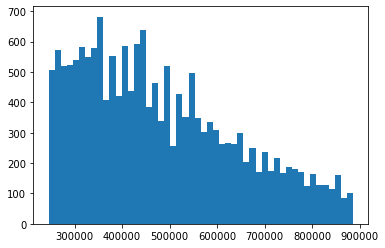

In [6]:
fig, ax = plt.subplots()
ax.hist(house_data['price'], bins=50);

In [9]:
features = ['sqft_living', 'lat', 'long']

X = house_data[features]
y = house_data['price'].values

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

## Why do we need to scale our data?

Scaling means that you're transforming your data so that it fits within a specific scale, like 0-100 or 0-1. You want to scale data when you're using methods based on measures of how far apart data points
Feature scaling is essential for machine learning algorithms that calculate distances between data. If not scaled, the feature with a higher value range starts dominating when calculating distances. 

In [13]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [14]:
X_train_scaled.shape

(12960, 3)

## Lets use Sklearn's KNN implementation where k=5

In [16]:
from sklearn.neighbors import KNeighborsRegressor

In [18]:
nn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

nn.fit(X_train_scaled, y_train)

sk_preds = nn.predict(X_test_scaled)

rmse = np.sqrt(mean_squared_error(y_test,sk_preds))

print(f'Root Mean Squared Error: {rmse:.2f}')

Root Mean Squared Error: 82854.02


## Choosing the optimal number of neighbors: Behavior of the model with increasing k

C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was

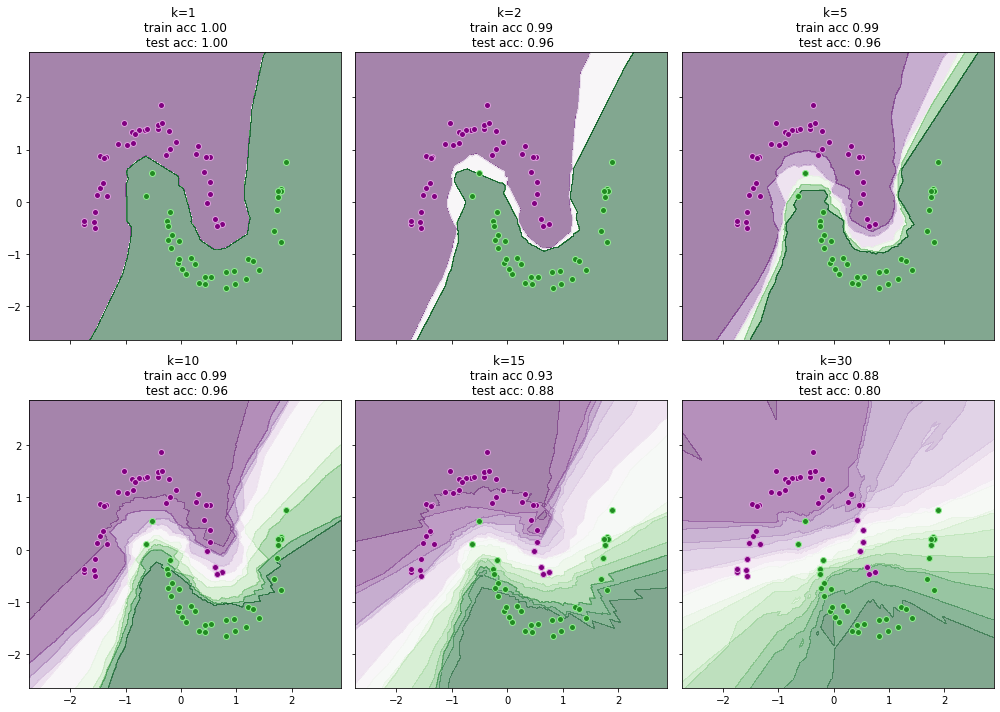

In [19]:
#visualisations d'un problème de classification

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 10), sharey=True, sharex=True)

X_train_scaled_fake, X_test_scaled_fake, y_train_fake, y_test_fake = preprocess(generate_moons_df(n_samples=100, noise=0.1))

ks = [1, 2, 5, 10 , 15, 30]

for k, ax in zip(ks, axes.flatten()):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled_fake.drop('target', axis=1), y_train_fake)
    
    train_preds = knn.score(X_train_scaled_fake.drop('target', axis=1), y_train_fake)
    test_preds = knn.score(X_test_scaled_fake.drop('target', axis=1), y_test_fake)
    
    ax.set_title(f'k={knn.n_neighbors} \n train acc {train_preds:.2f} \n test acc: {test_preds:.2f}')
    plot_boundaries(knn, X_test_scaled_fake, X_train_scaled_fake, ax=ax)
    
fig.tight_layout()

### Compare the KNN classifier and logistic regression

In [21]:
X_train_scaled, X_test_scaled, y_train, y_test = preprocess(generate_moons_df(n_samples= 20, noise=0.1))

# fit knn model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled.drop('target', axis=1),y_train)

# fit logistic
logistic = LogisticRegression(solver='liblinear')
logistic.fit(X_train_scaled.drop('target', axis=1),y_train);

C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


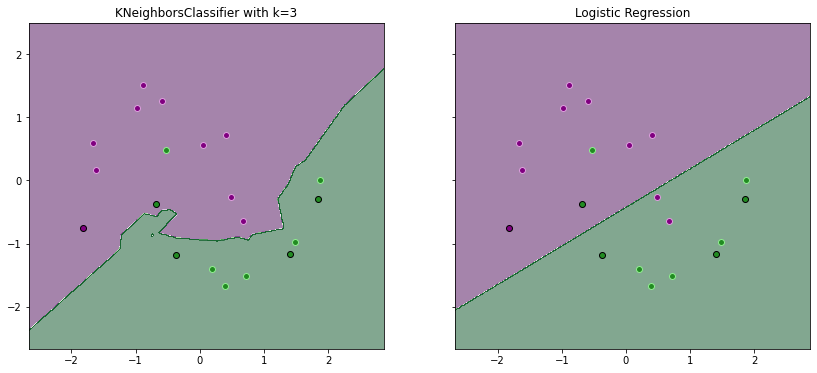

In [22]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

axes[0].set_title(f'KNeighborsClassifier with k={knn.n_neighbors}')
plot_boundaries(knn, X_test_scaled, X_train_scaled, ax=axes[0], show_test=True, plot_probas=False)

axes[1].set_title('Logistic Regression')
plot_boundaries(logistic, X_test_scaled, X_train_scaled, ax=axes[1], plot_probas=False, show_test=True)

In [ ]:
# what can you say about Knn compared to logistic regression

Comme nous pouvons le voir ici, la régression logistique sans ingénierie des caractéristiques ne peut nous donner qu'une limite linéaire, mais KNN peut déjà commencer à suivre les relations non linéaires dans nos données.


## Creating our own implementation of KNN regressor

In [23]:
def eudlecian_distance(x1,x2):
#     print('x=',x1,'y=',x2)
#     print(np.sqrt(np.sum((x1-x2)**2)))
    return np.sqrt(np.sum((x1-x2)**2))

In [24]:
from collections import Counter

In [25]:
def predict(x_test,k=3):
    #calculating distance
    distances = [eudlecian_distance(x_test,i) for i in X_train]
    #now lets take the k nearest sample
    order_asc_distance = np.argsort(distances) #sorting the distance in asc order
    print(order_asc_distance[:k])
    finding_target = [y_train[i] for i in order_asc_distance[:k] ]
    print(finding_target)
    #majority neighbour for this we will use counter module from collection
    most_near_classes = Counter(finding_target).most_common(1)
    print(most_near_classes)
    return most_near_classes[0][0]